<a href="https://colab.research.google.com/github/Ahmed-M-Elshazly/Homework-7/blob/main/Homework_7_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 7
#Problem 2
#Ahmed Elshazly
#801420724

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score
import time
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F

In [ ]:
# Set device
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=True, download=True)
val_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
img, label = train_dataset[100]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 8, 'ship')

In [ ]:
len(train_dataset)

50000

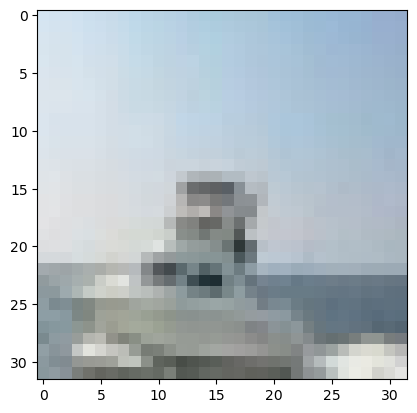

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=True, download=False,
                          transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

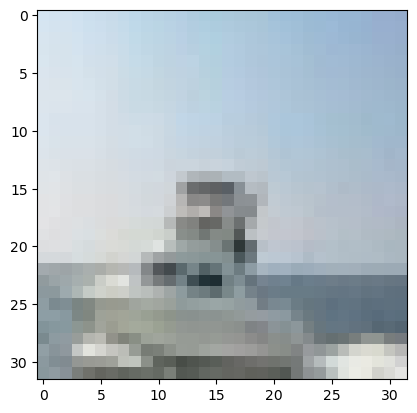

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))  # <1>
plt.show()

In [ ]:
train_mean=imgs.view(3, -1).mean(dim=1)
train_std=imgs.view(3, -1).std(dim=1)
print(train_mean)
print(train_std)


tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [ ]:
transforms.Normalize(train_mean, train_std)


Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

In [ ]:
transformed_train_dataset = torchvision.datasets.CIFAR10(
    '../data-unversioned/p1ch7/', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
train_loader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=64, shuffle=True)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


model = NetResDeep(n_chans1=32, n_blocks=10).to(device1)

Epoch: 1, Train Loss: 1.581716, Epoch Runtime: 11.31 seconds
Epoch: 2, Train Loss: 1.028421, Epoch Runtime: 11.34 seconds
Epoch: 3, Train Loss: 1.552702, Epoch Runtime: 11.29 seconds
Epoch: 4, Train Loss: 0.950745, Epoch Runtime: 11.60 seconds
Epoch: 5, Train Loss: 0.849681, Epoch Runtime: 11.34 seconds
Epoch: 6, Train Loss: 0.756967, Epoch Runtime: 11.39 seconds
Epoch: 7, Train Loss: 0.471196, Epoch Runtime: 10.96 seconds
Epoch: 8, Train Loss: 0.238151, Epoch Runtime: 8.73 seconds
Epoch: 9, Train Loss: 1.022087, Epoch Runtime: 9.10 seconds
Epoch: 10, Train Loss: 0.764105, Epoch Runtime: 10.96 seconds
Epoch: 11, Train Loss: 0.692743, Epoch Runtime: 10.96 seconds
Epoch: 12, Train Loss: 0.319367, Epoch Runtime: 10.51 seconds
Epoch: 13, Train Loss: 0.308712, Epoch Runtime: 11.16 seconds
Epoch: 14, Train Loss: 0.238492, Epoch Runtime: 10.59 seconds
Epoch: 15, Train Loss: 0.554344, Epoch Runtime: 11.04 seconds
Epoch: 16, Train Loss: 0.393755, Epoch Runtime: 10.97 seconds
Epoch: 17, Train Lo

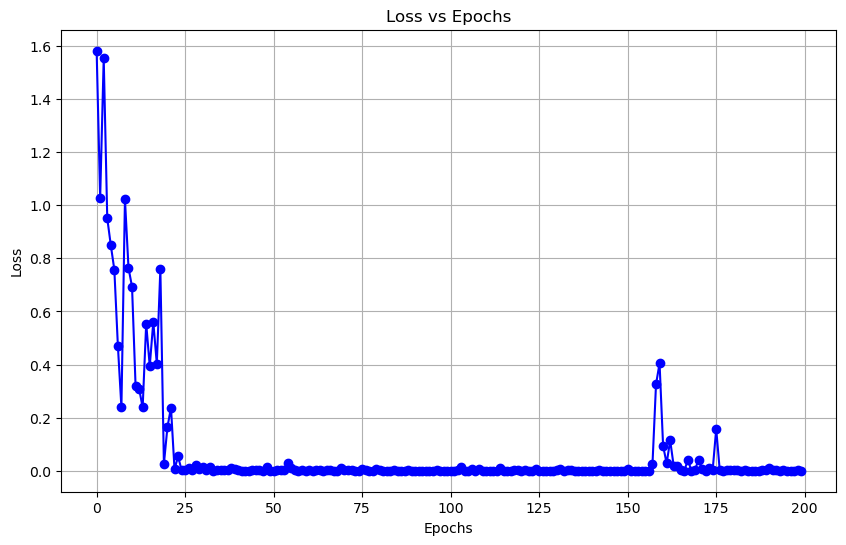

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# Training loop
num_epochs = 200
total_start_time = time.time()
losses=[]
for epoch in range(num_epochs):
    start_time = time.time()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device1), labels.to(device1)
        outputs=model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Epoch: {epoch+1}, Train Loss: {float(loss):.6f}, Epoch Runtime: {training_time:.2f} seconds")
    losses.append(float(loss))

# Print total training time
total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')
# Plotting loss vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-', color='b')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
val_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=False, download=False,
                          transform=transforms.ToTensor())

In [ ]:
imgs = torch.stack([img_t for img_t, _ in val_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 10000])

In [ ]:
val_mean=imgs.view(3, -1).mean(dim=1)
val_std=imgs.view(3, -1).std(dim=1)
print(val_mean)
print(val_std)


tensor([0.4942, 0.4851, 0.4504])
tensor([0.2467, 0.2429, 0.2616])


In [ ]:
transforms.Normalize(val_mean, val_std)

Normalize(mean=tensor([0.4942, 0.4851, 0.4504]), std=tensor([0.2467, 0.2429, 0.2616]))

In [ ]:
transformed_val_dataset = torchvision.datasets.CIFAR10(
    '../data-unversioned/p1ch7/', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
val_loader = torch.utils.data.DataLoader(transformed_val_dataset, batch_size=64, shuffle=False)

In [ ]:
correct=0
total=0
with torch.no_grad():
  for imgs, labels in val_loader:
      imgs, labels = imgs.to(device1), labels.to(device1)
      batch_size=imgs.shape[0]
      outputs=model(imgs)
      _,predicted=torch.max(outputs,dim=1)
      total+=labels.shape[0]
      correct+=int((predicted==labels).sum())
print("Validation Accurracy:%f", correct/total)

Validation Accurracy:%f 0.7225


In [ ]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
total_params, trainable_params = get_model_size(model)
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")

  Total parameters: 537290
  Trainable parameters: 537290
